In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DATASET
!unzip HOVA10.zip

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!pip install keras==3.3.3

In [ ]:
import os
import tensorflow as tf
# from model.rep_efficientnet_v2 import EfficientNetV2B3
import keras
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from model.losses import categorical_focal_crossentropy
from keras.utils import image_dataset_from_directory
import tensorflow as tf

import keras
import numpy as np
from keras import Sequential, Model
from keras.layers import Input, Layer, AveragePooling2D, Conv2D, BatchNormalization, Dropout, Dense, Flatten, ReLU, ZeroPadding2D


def unfreeze_model(model, unfree=False, precent=10):
    length = len(model.layers)
    top_layer = int(length * (precent/100))
    print("length : ", length, "top_layer: ", top_layer, "int(precent/100): ", precent/100)
    if unfree:
        # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
        top_layer *= -1
        for layer in model.layers[top_layer:]:
            if not isinstance(layer, keras.layers.BatchNormalization):
                layer.trainable = True
                print("Layer >> ", layer)
    return model

In [ ]:
base_model = keras.applications.EfficientNetB4(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    include_top=False,
)

# Freeze the base_model
base_model.trainable = False

# base_model = unfreeze_model(base_model, unfree=True, precent=30) # unfree 30% top layer
# base_model.summary(show_trainable=True)

In [ ]:
train_dir = "/content/drive/MyDrive/DATASET/HOVA10/train"
test_dir = "/content/drive/MyDrive/DATASET/HOVA10/val/"
size = (224, 224)
batch_size = 32
train = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=size,
    shuffle=True,
)
val = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=size,
    shuffle=True,
)

Found 1533 files belonging to 10 classes.
Found 657 files belonging to 10 classes.


In [ ]:
def scale_up_lora(inputs, units, lora_rank, lora_num_layer, activation=None, name='lora'):
    lora_denses = []
    for i in range(lora_num_layer):
        lora_denses.append(keras.layers.Dense(units, activation=activation,
                                              lora_rank=lora_rank, name=f'{name}_dense_{i}')(inputs))
    lora_denses.append(inputs)
    x_nlora = keras.layers.Add(name=f'{name}_add')(lora_denses)
    # x_silu2 = keras.activations.silu(x_nlora)
    return x_nlora

In [ ]:
inputs = keras.Input(shape=(*size, 1))
# x_rescaling = keras.layers.Rescaling(scale=1./127.5, offset=-1)(inputs)
x_base_model = base_model(inputs, training=False)
x_flatten = keras.layers.GlobalAveragePooling2D()(x_base_model)
x_dropout1 = keras.layers.Dropout(0.3)(x_flatten)
x_silu1 = keras.activations.silu(x_dropout1)
x_nlora = scale_up_lora(x_silu1, units=x_silu1.shape[1], lora_rank=1, lora_num_layer=5)
# x_flora = keras.layers.Add(name=f'flora_layer')([x_flatten, x_nlora])

x_dropout2 = keras.layers.Dropout(0.2)(x_nlora)
outputs = keras.layers.Dense(10, activation='softmax')(x_dropout2)
model = keras.Model(inputs, outputs)
init_weights = model.get_weights()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb4            │ (None, 7, 7, 1792)     │     17,673,823 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1792)           │              0 │ efficientnetb4[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1792)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ silu (Silu)               │ (None, 1792)           │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_0 (Dense)      │ (None, 1792)           │      3,216,640 │ silu[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_1 (Dense)      │ (None, 1792)           │      3,216,640 │ silu[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_2 (Dense)      │ (None, 1792)           │      3,216,640 │ silu[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_3 (Dense)      │ (None, 1792)           │      3,216,640 │ silu[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_dense_4 (Dense)      │ (None, 1792)           │      3,216,640 │ silu[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lora_add (Add)            │ (None, 1792)           │              0 │ lora_dense_0[0][0],    │
│                           │                        │                │ lora_dense_1[0][0],    │
│                           │                        │                │ lora_dense_2[0][0],    │
│                           │                        │                │ lora_dense_3[0][0],    │
│                           │                        │                │ lora_dense_4[0][0],    │
│                           │                        │                │ silu[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1792)           │              0 │ lora_add[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10)             │         17,930 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,774,953 (128.84 MB)

 Trainable params: 44,810 (175.04 KB)

 Non-trainable params: 33,730,143 (128.67 MB)

In [ ]:
import os
save_dir = "/content/drive/MyDrive/DATASET/logs/hova10"
os.makedirs(save_dir, exist_ok=True)
length = len(os.listdir(save_dir))
save_dir = os.path.join(save_dir, f'train{length}')
os.makedirs(save_dir, exist_ok=True)
print(">>>>>>>>>> ", save_dir)

>>>>>>>>>>  /content/drive/MyDrive/DATASET/logs/hova10/train6


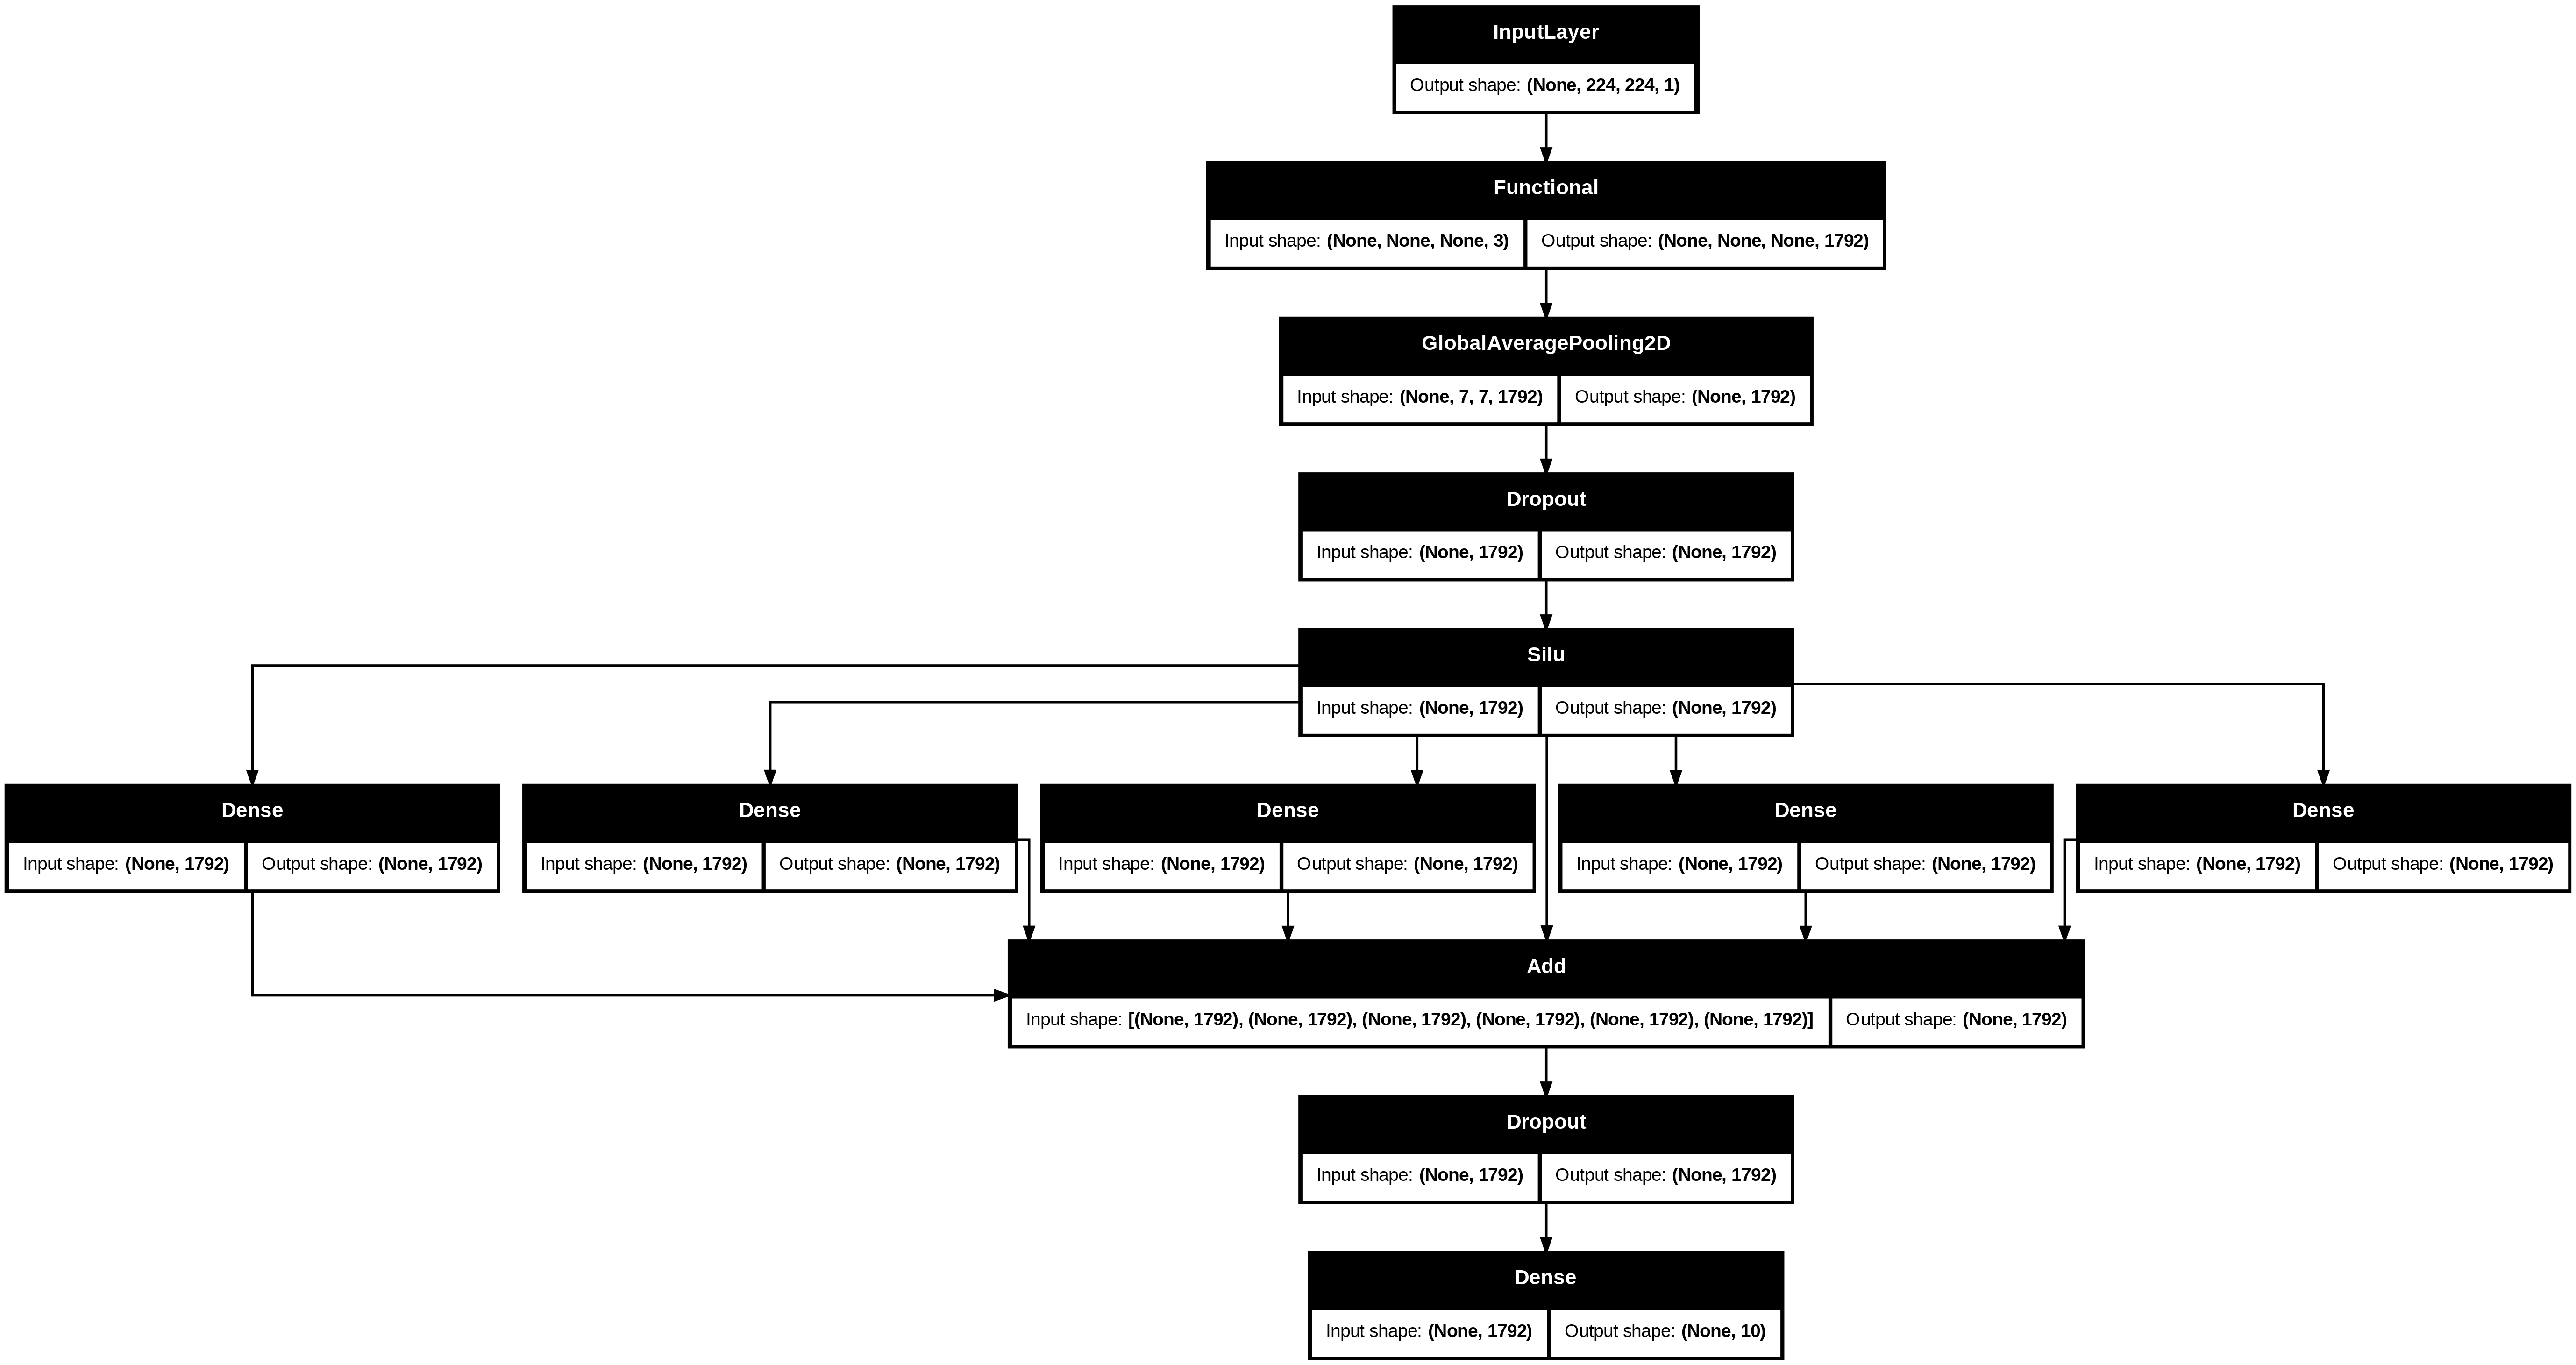

In [ ]:
keras.utils.plot_model(model, to_file=os.path.join(save_dir, 'model.png'), show_shapes=True)

In [ ]:
METRICS = [
    # tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='Top1'),
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
]

In [ ]:
import shutil


if os.path.exists(save_dir):
    shutil.rmtree(save_dir)

checkpoint_filepath = os.path.join(save_dir, 'best.weights.h5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

model_stop = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy',
                                        verbose=1,
                                        patience=10,
                                        mode='max',
                                        restore_best_weights=False),
my_callbacks = [
    model_stop,
    model_checkpoint_callback
]

In [ ]:
focal = keras.losses.categorical_focal_crossentropy
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), loss=[focal], metrics = METRICS)

In [ ]:
model.set_weights(init_weights)
epoch = 50
history = model.fit(
        x = train,
        epochs = epoch,
        validation_data = val,
        batch_size=batch_size,
        shuffle=True,
        callbacks=my_callbacks,
        # steps_per_epoch = len(train.file_paths) // batch_size,
        # validation_steps=len(val.file_paths) // batch_size,
        # sample_weight=train.sample_weight
        # workers=5
        #  class_weight = class_weight
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 642s 13s/step - categorical_accuracy: 0.2018 - loss: 0.4609 - val_categorical_accuracy: 0.5266 - val_loss: 0.3004
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 585s 12s/step - categorical_accuracy: 0.4839 - loss: 0.2971 - val_categorical_accuracy: 0.6682 - val_loss: 0.2115
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 577s 11s/step - categorical_accuracy: 0.6234 - loss: 0.2132 - val_categorical_accuracy: 0.7671 - val_loss: 0.1586
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 621s 13s/step - categorical_accuracy: 0.7273 - loss: 0.1571 - val_categorical_accuracy: 0.8067 - val_loss: 0.1273
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 620s 12s/step - categorical_accuracy: 0.7715 - loss: 0.1293 - val_categorical_accuracy: 0.8326 - val_loss: 0.1081
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 580s 11s/step - categorical_accuracy: 0.8142 - loss: 0.1051 - val_categorical_accuracy: 0.8356 - val_loss: 0.0963
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 665s 14s/step - categorical_accuracy: 0.8208 - los

In [ ]:
model.save_weights(os.path.join(save_dir, 'last.weights.h5'))

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)
hist_csv_file = os.path.join(save_dir, 'history.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f, index=False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df_train = pd.read_csv(hist_csv_file)
print(df_train.columns)

loss = df_train['loss'].values
val_loss = df_train['val_loss'].values

acc = df_train['categorical_accuracy'].values
val_acc = df_train['val_categorical_accuracy'].values

logs_train = [
    [[loss, val_loss, "plot loss", ["loss", "val_loss"]], [acc, val_acc, "plot categorical_accuracy", ["acc", "val_acc"]]],
]

fig, axs = plt.subplots(1, 2, figsize=(16, 7), squeeze=False)
eps = [i for i in range(0, len(loss))]
for row, sub_logs_train in enumerate(logs_train):
    for col, (train, val, title, legend) in enumerate(sub_logs_train):
        # print(legend)
        axs[row][col].plot(eps, train)
        axs[row][col].plot(eps, val)
        axs[row][col].set_title(title)
        axs[row][col].legend(legend)
        axs[row][col].set_xlabel("epochs")
        axs[row][col].set_ylabel("scores")

fig.show()

In [ ]:
model.load_weights(os.path.join(save_dir, "best.weights.h5"))
val_metrics = model.evaluate(val, batch_size=batch_size)
print("Val Loss: ", val_metrics[0])
print("Val Acc: ", val_metrics[1])